In [2]:
using QuantumBayesian
using PyPlot

# Single Qubit Evolution Tests

**Justin Dressel**, 12/6/2016 <br />
*Institute for Quantum Studies, Chapman University*

Benchmark various integration algorithms for a single qubit damped Rabi oscillation, for comparison with the DifferentialEquations package tested in a separate notebook.

## Basic Definitions

### Qubit Hilbert space

In [3]:
q = qubit()

QFactor: Qubit
Dims  : 2
Ops   : 'x', 'd', 'i', 'u', 'y', 'z'


### Global Constants

In [4]:
Ω  = 2*π;        # Rabi frequency
τ = 3.0;         # Measurement collapse timescale
Γ = 1/(2*τ);     # Measurement dephasing rate (quantum-limited efficiency)
T = (0.0, 6*τ);  # Time duration of simulation;

dt = 1e-2;       # Simulation timestep (coarse to show method precision);

### Common Trajectory and Plotting Code

In [5]:
# Initial conditions (matrix and superket)
init = ground(q)
sinit = superket(init)

# Bloch expectation values (matrix and superket)
fs  = collect(ρ -> real(expect(ρ, q(l))) for l in ['x','y','z'])
sfs = collect(ρ -> real(expect(unsuperket(ρ),q(l))) for l in ['x','y','z'])

# Trajectory and plotting function
function solve(inc, init, dt, T, fs, plot_title; readout=false, n=1)
    figure(1)
    if n==1
        out = trajectory(inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = trajectory(inc, init, T, fs..., dt=dt)
        plot(out[1].t,out[1],label=L"$x$",color="r")
        plot(out[2].t,out[2],label=L"$y$",color="g")
        plot(out[3].t,out[3],label=L"$z$",color="b")
    else
        out = ensemble(1, inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = ensemble(n, inc, init, T, fs..., dt=dt)
        m1 = mean(out[1]); m2 = mean(out[2]); m3 = mean(out[3]);
        s1 = std(out[1]); s2 = std(out[2]); s3 = std(out[3]);
        plot(out[1].t,m1,label=L"$x$",color="r")
        plot(out[2].t,m2,label=L"$y$",color="g")
        plot(out[3].t,m3,label=L"$z$",color="b")
        fill_between(out[1].t, m1-s1, m1+s1, color="r", alpha=0.2, antialiased=true)
        fill_between(out[2].t, m2-s2, m2+s2, color="g", alpha=0.2, antialiased=true)
        fill_between(out[3].t, m3-s3, m3+s3, color="b", alpha=0.2, antialiased=true)
    end
    ax = gca()
    ax.set_ylim([-1.1,1.1])
    xlabel(L"$t (2\pi/\Omega)$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    show()
    if readout
        figure(2)
        if n==1
            plot(out[4].t,out[4],label=L"$r_z$",color="k")
        else
            m4 = mean(out[4]); s4 = std(out[4]); 
            plot(out[4].t,m4,label=L"$r_z$",color="k")
            fill_between(out[4].t, m4-s4, m4+s4, color="k", alpha=0.2, antialiased=true)
        end
        xlabel(L"$t (2\pi/\Omega)$")
        ylabel("Stochastic readout")
        title(plot_title*" Readout")
        legend()
        show()
    end
end;

## Time-independent Rabi Hamiltonian

In [6]:
# Hamiltonian
H = (Ω/2)*q('y');
# Measurement dephasing
DM = sqrt(Γ/2)*q('z');
# Stochastic monitoring (unit efficiency)
SM = [(q('z'), τ, 1.0)];

### Coherent (Hamiltonian) Evolution

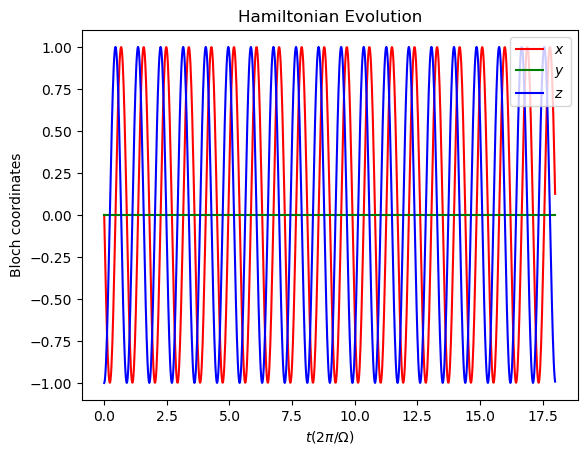

  0.066884 seconds (69.65 k allocations: 5.129 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.061424970626831055
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 29304.043317095893
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


In [32]:
solve(ham(dt, H), init, dt, T, fs, "Hamiltonian Evolution")

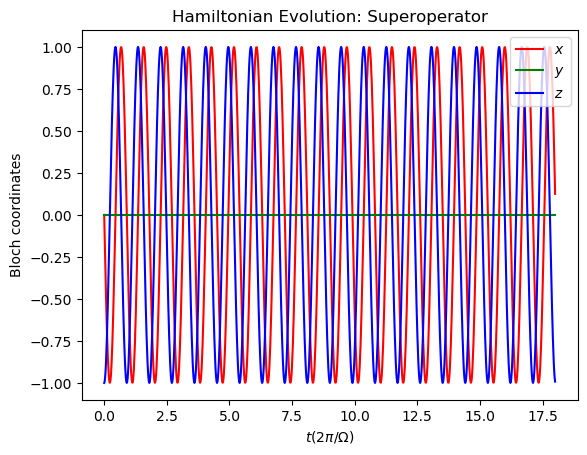

  0.008704 seconds (20.72 k allocations: 1.228 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.004695892333984375
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 383313.72867587325
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


In [30]:
solve(sham(dt, H), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

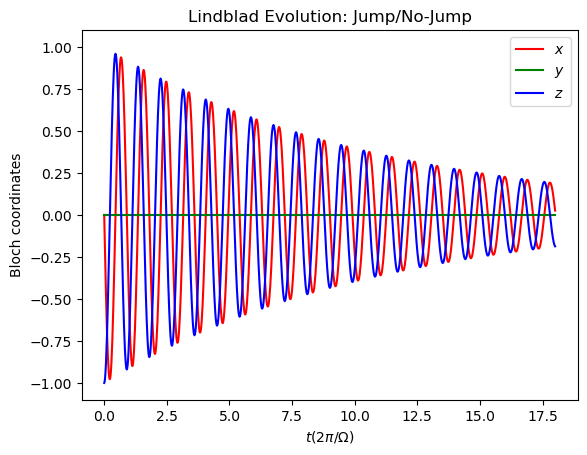

  0.032056 seconds (279.54 k allocations: 23.675 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.031742095947265625
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 56707.0304049994
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


In [10]:
solve(lind(dt, H, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

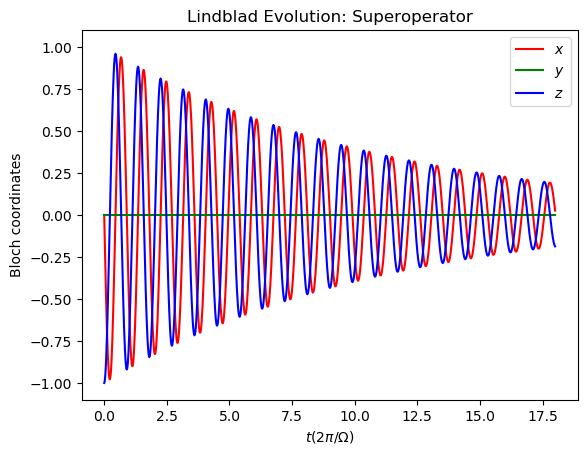

  0.004497 seconds (63.68 k allocations: 3.941 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.004127025604248047
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 436149.46273830155
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


In [11]:
solve(slind(dt, H, clist=[DM]), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.3546590805053711
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 5075.296528246484
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


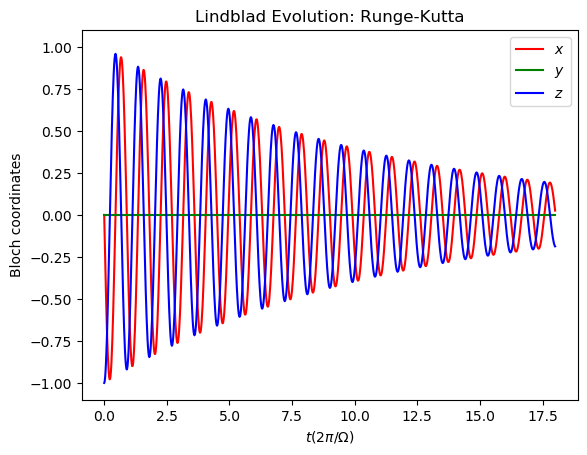

  0.355260 seconds (1.39 M allocations: 103.609 MiB, 74.71% gc time)


In [12]:
solve(lind_rk4(dt, H, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:549


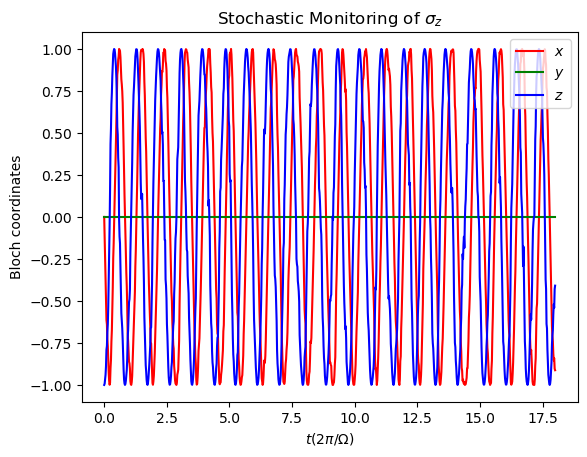

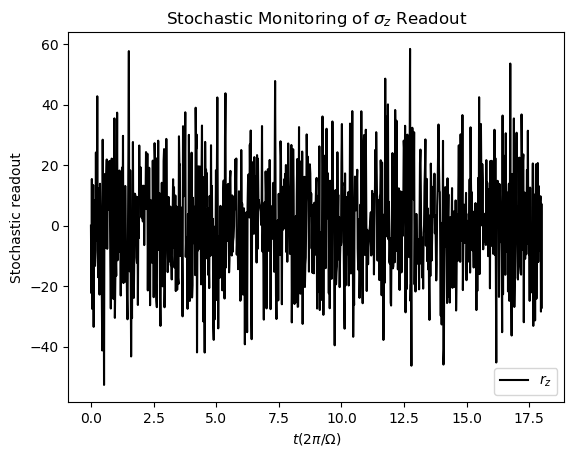

  0.215663 seconds (263.72 k allocations: 20.255 MiB, 77.75% gc time)


┌ Info: Time elapsed: 
│   elapsed = 0.21441102027893066
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 8395.090875731816
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


In [31]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$", readout=true)

(Note: no parallelization performed here to benchmark serial execution of an ensemble simulation. Plotted is the mean with shaded standard deviation behind.)

┌ Info: Trajectories: 
│   n = 2500
│   , steps each:  = , steps each: 
│   N = 1799
│   , points each:  = , points each: 
│   min(N, points) = 1000
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:472
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:475


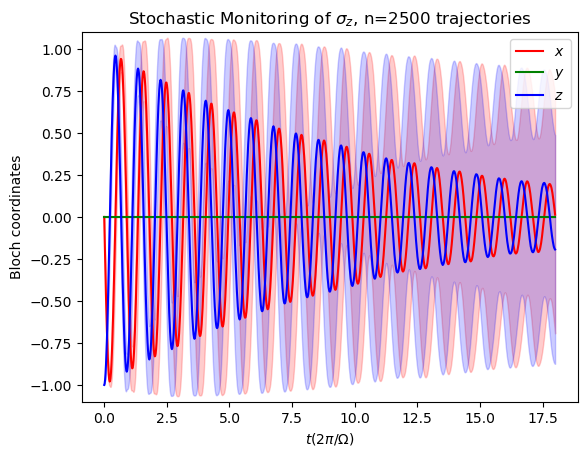

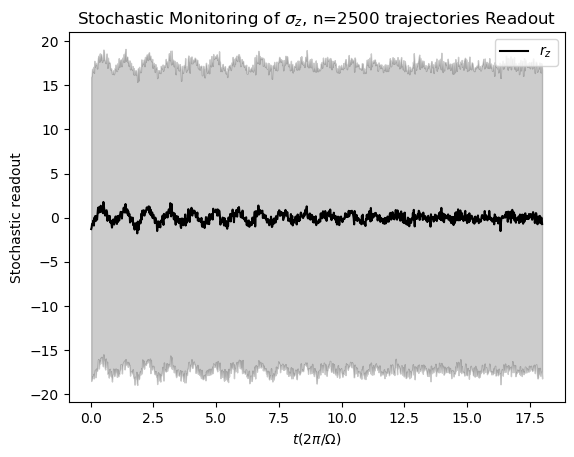

 60.769843 seconds (659.03 M allocations: 49.427 GiB, 11.19% gc time)


┌ Info: Time elapsed: 
│   elapsed = 60.50882005691528
│    s, Steps:  =  s, Steps: 
│   steps = 2500000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 41316.2907101555
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:493


In [14]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$, n=2500 trajectories", readout=true, n=2500)

## Time-dependent Rabi Pulse

In [15]:
# Hamiltonian
f(t::Float64) = 2*exp(-(t-3*τ)^2/2)/sqrt(2π)
h(t::Float64) = f(t)*(Ω/2)*q('y');

### Coherent (Hamiltonian) Evolution

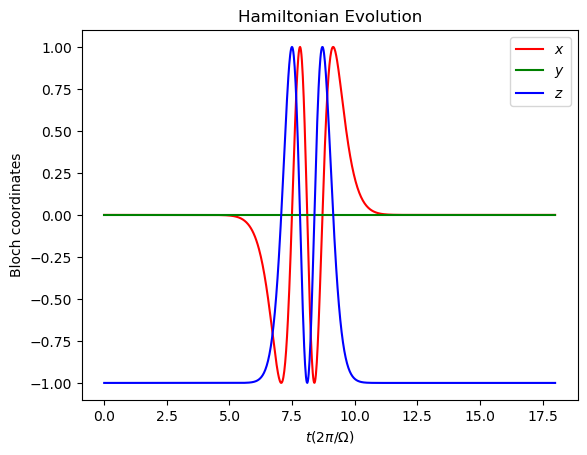

  0.017333 seconds (164.62 k allocations: 12.473 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.016903162002563477
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 106488.95157764081
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


In [16]:
solve(ham(dt, h), init, dt, T, fs, "Hamiltonian Evolution")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.16558289527893066
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 10870.688044002563
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


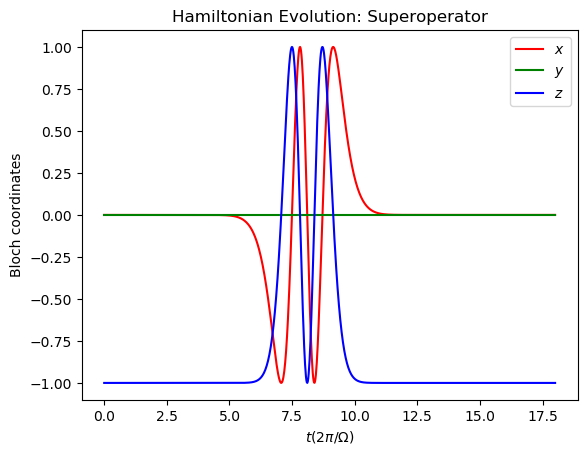

  0.166082 seconds (145.83 k allocations: 12.244 MiB, 89.38% gc time)


In [17]:
solve(sham(dt, h), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

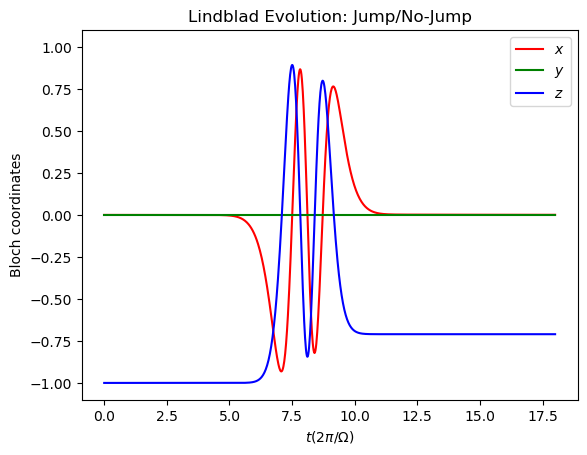

  0.036183 seconds (372.51 k allocations: 30.958 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.035865068435668945
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 50188.1100053846
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


In [18]:
solve(lind(dt, h, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.1076970100402832
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 16713.555922552765
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


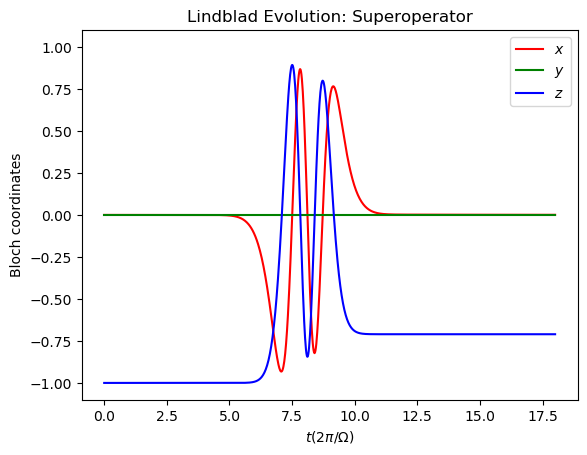

  0.108324 seconds (301.33 k allocations: 35.962 MiB, 74.17% gc time)


In [19]:
solve(slind(dt, h, clist=[DM]), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

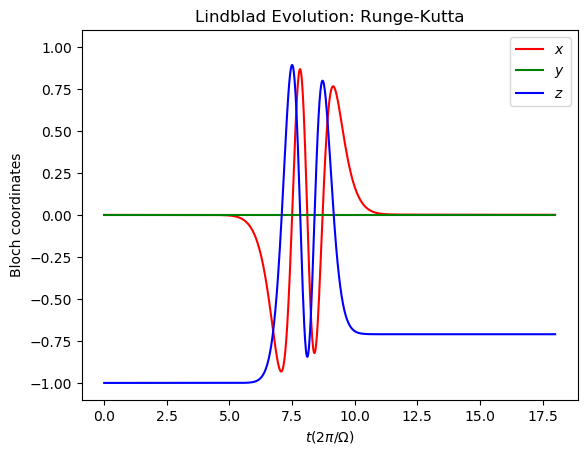

  0.076510 seconds (1.51 M allocations: 107.841 MiB, 18.64% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.076171875
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 23630.76923076923
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


In [20]:
solve(lind_rk4(dt, h, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

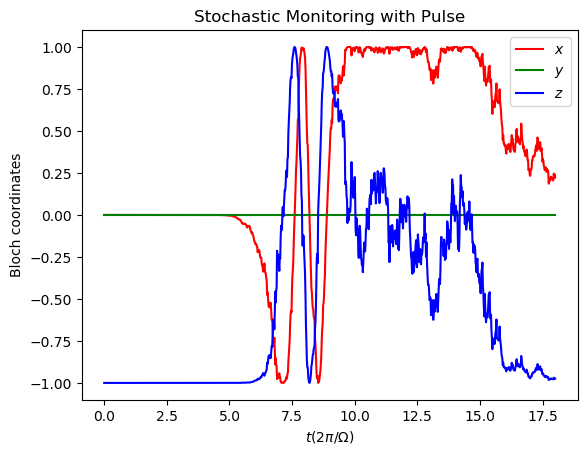

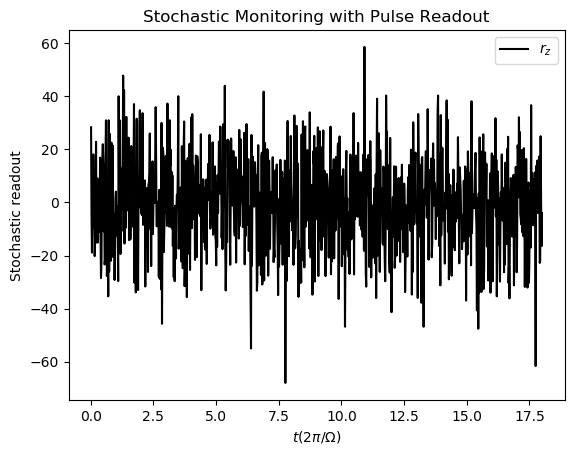

  0.032498 seconds (356.55 k allocations: 27.527 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:548
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:549
┌ Info: Time elapsed: 
│   elapsed = 0.032145023345947266
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 55996.22624716301
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:566


In [21]:
solve(meas(dt, h, mclist=SM), init, dt, T, fs, "Stochastic Monitoring with Pulse", readout=true)

┌ Info: Trajectories: 
│   n = 2500
│   , steps each:  = , steps each: 
│   N = 1799
│   , points each:  = , points each: 
│   min(N, points) = 1000
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:472
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:475


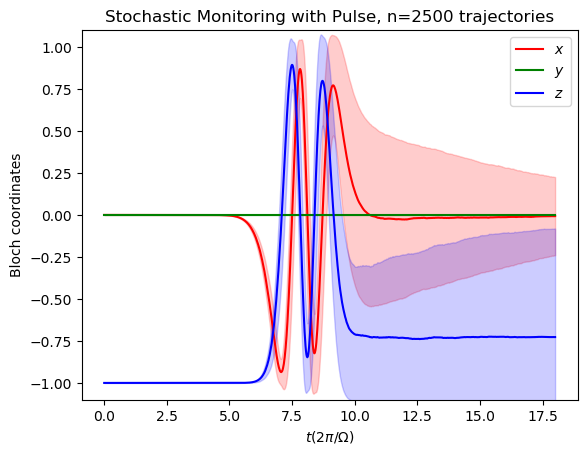

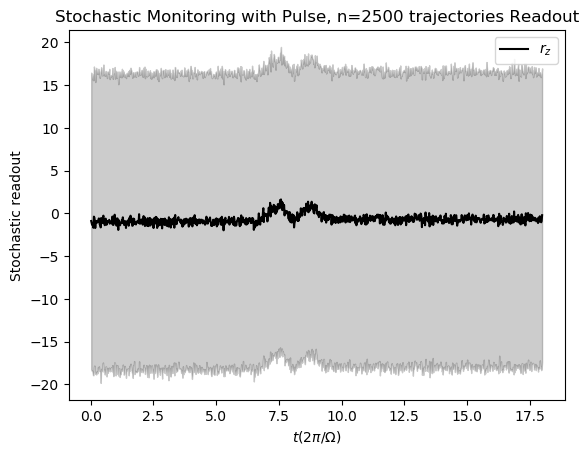

121.470161 seconds (890.90 M allocations: 67.182 GiB, 7.73% gc time)


┌ Info: Time elapsed: 
│   elapsed = 121.4241669178009
│    s, Steps:  =  s, Steps: 
│   steps = 2500000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 20588.982106769534
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumEvolution.jl:493


In [22]:
solve(meas(dt, h, mclist=SM), init, dt, T, fs, "Stochastic Monitoring with Pulse, n=2500 trajectories", readout=true, n=2500)

## Version Information

In [33]:
versioninfo()

Julia Version 1.4.1
Commit 381693d3df* (2020-04-14 17:20 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7660U CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
